# Wiktionary Etymology Database Analysis

This notebook provides SQL queries to explore the Wiktionary etymology database.

**Database Schema:**
```sql
CREATE TABLE words (
  word TEXT NOT NULL,
  language TEXT NOT NULL,
  lang_code TEXT,
  pos TEXT,
  etymology_index INTEGER NOT NULL DEFAULT 0,
  etymology_text TEXT,
  etymology_templates TEXT,  -- JSON array
  categories TEXT,           -- JSON array
  senses TEXT,               -- JSON array
  full_data TEXT,            -- Complete JSON
  PRIMARY KEY (word, language, pos, etymology_index)
);
```

In [1]:
# Setup
import sqlite3
import pandas as pd
import json

# Connect to database
DB_PATH = 'data/wiktionary.db'
conn = sqlite3.connect(DB_PATH)

# Helper function to run queries and display results
def query(sql, params=None):
    """Execute SQL query and return pandas DataFrame"""
    if params:
        return pd.read_sql_query(sql, conn, params=params)
    return pd.read_sql_query(sql, conn)

print(f"Connected to {DB_PATH}")

Connected to data/wiktionary.db


/var/folders/g7/8vxyyp0n0sz9vxw2bpxdd4jc0000gn/T/ipykernel_21939/1587919576.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Database Statistics

In [2]:
# Overall database statistics
stats_query = """
SELECT 
    COUNT(*) as total_entries,
    COUNT(DISTINCT word) as unique_words,
    COUNT(DISTINCT language) as unique_languages,
    COUNT(CASE WHEN etymology_text IS NOT NULL THEN 1 END) as entries_with_etymology,
    COUNT(CASE WHEN etymology_index > 0 THEN 1 END) as entries_with_multiple_etymologies
FROM words
"""

query(stats_query)

,total_entries,unique_words,unique_languages,entries_with_etymology,entries_with_multiple_etymologies
0,10440227,8703230,4760,2779507,268702


In [2]:
# Top 20 languages by entry count
top_languages = """
SELECT 
    language,
    COUNT(*) as entry_count,
    COUNT(CASE WHEN etymology_text IS NOT NULL THEN 1 END) as with_etymology,
    ROUND(COUNT(CASE WHEN etymology_text IS NOT NULL THEN 1 END) * 100.0 / COUNT(*), 1) as etymology_percentage
FROM words
GROUP BY language
ORDER BY entry_count DESC
LIMIT 50
"""

top_languages_result = query(top_languages)
top_languages_result

,language,entry_count,with_etymology,etymology_percentage
0,English,1442009,517864,35.9
1,Latin,883915,56571,6.4
2,Spanish,796603,63013,7.9
3,Italian,620606,85549,13.8
4,Russian,439968,44164,10.0
5,Portuguese,424173,46219,10.9
6,French,398312,55140,13.8
7,German,362401,73592,20.3
8,Chinese,315419,25239,8.0
9,Swedish,307591,47710,15.5


Text(0.5, 0, '# of Entries')

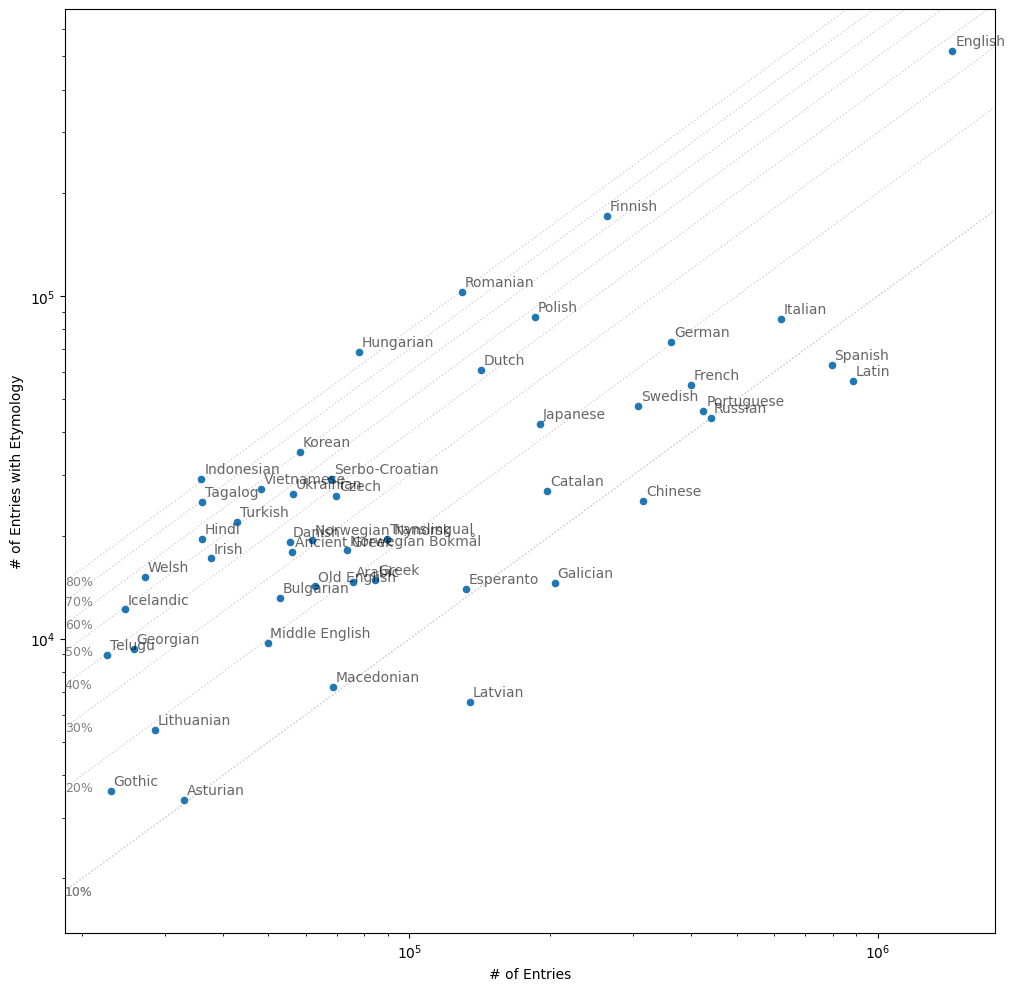

In [45]:
df = top_languages_result[lambda x: ~x.language.isin(['Mandarin'])]

ax = df.plot.scatter('entry_count', 'with_etymology', logx=True, logy=True, figsize=(12, 12))

for i, point in df.iterrows():
    ax.annotate(point['language'],          # The label text
                xy=(point['entry_count'], point['with_etymology']), # The point's coordinates
                xytext=(2, 2),          # Offset the text for readability
                textcoords='offset points', # Use offset points for text position
                alpha=0.6,
                ha='left',              # Horizontal alignment
                va='bottom')            # Vertical alignment

# Get current axis limits to ensure lines span the visible area
xmin, xmax = ax.get_xlim()

# Define the ratios you want to show (e.g., 10%, 1%, 0.1%)
ratios = [0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for r in ratios:
    # Use axline to draw an infinite diagonal line
    # For a ratio r, y = r * x. We pick two points (1, r) and (10, 10*r)
    ax.axline((xmin, xmin*r), (xmin*10, 10*xmin*r), color='lightgray', linestyle=':', linewidth=1, zorder=0)
    
    # Optional: Add labels to the lines
    ax.text(xmin, xmin * r, f'{r*100:g}%', color='gray', fontsize=9, va='center')

# Ensure limits don't change after adding lines
ax.set_xlim(xmin, xmax)

ax.set_ylabel('# of Entries with Etymology')
ax.set_xlabel('# of Entries')


## 2. Exploring Specific Words

In [4]:
# Find all entries for a specific word (example: "cheese")
word_lookup = """
SELECT 
    word,
    language,
    pos,
    etymology_index,
    SUBSTR(etymology_text, 1, 150) as etymology_preview
FROM words
WHERE word = 'cheese'
    AND language = 'English'
ORDER BY pos, etymology_index
"""

query(word_lookup)

,word,language,pos,etymology_index,etymology_preview
0,cheese,English,intj,0,Perhaps an alteration of cheers.
1,cheese,English,noun,0,Etymology tree\nLatin cāseusbor.\nProto-German...
2,cheese,English,noun,1,Though commonly claimed to be a borrowing of P...
3,cheese,English,noun,2,From cheesy.
4,cheese,English,verb,0,Etymology tree\nLatin cāseusbor.\nProto-German...
5,cheese,English,verb,1,Etymology unknown. Possibly an alteration of c...
6,cheese,English,verb,2,From cheesy.


In [5]:
# Get full details for a specific word entry
word = 'cheese'
language = 'English'
pos = 'noun'
etym_index = 0

result = query("""
    SELECT * FROM words 
    WHERE word = ? AND language = ? AND pos = ? AND etymology_index = ?
""", params=(word, language, pos, etym_index))

if len(result) > 0:
    entry = result.iloc[0]
    print(f"Word: {entry['word']}")
    print(f"Language: {entry['language']}")
    print(f"Part of Speech: {entry['pos']}")
    print(f"Etymology Index: {entry['etymology_index']}")
    print(f"\nEtymology:\n{entry['etymology_text']}")
    
    if entry['etymology_templates']:
        templates = json.loads(entry['etymology_templates'])
        print(f"\nEtymology Templates ({len(templates)}):")
        for t in templates[:5]:
            print(f"  - {t.get('name', 'unknown')}: {t.get('args', {})}")
    
    if entry['senses']:
        senses = json.loads(entry['senses'])
        print(f"\nDefinitions ({len(senses)}):")
        for i, sense in enumerate(senses[:3], 1):
            gloss = sense.get('glosses', [''])[0] or sense.get('raw_glosses', [''])[0]
            print(f"  {i}. {gloss}")

Word: cheese
Language: English
Part of Speech: noun
Etymology Index: 0

Etymology:
Etymology tree
Latin cāseusbor.
Proto-Germanic *kāsijaz
Proto-West Germanic *kāsī
Old English ċīese
Middle English chese
English cheese
From Middle English chese, from Anglian Old English ċīese, from Proto-West Germanic *kāsī, borrowed from Latin cāseus. Doublet of queso.
Cognate with Saterland Frisian Síes (“cheese”), West Frisian tsiis (“cheese”), Dutch kaas (“cheese”), German Low German Kees (“cheese”), German Käse (“cheese”).

Etymology Templates (11):
  - etymon: {'1': 'en', '2': ':inh', '3': 'enm:chese<id:cheese>', 'id': 'dairy product', 'tree': '1'}
  - inh: {'1': 'en', '2': 'enm', '3': 'chese'}
  - inh: {'1': 'en', '2': 'ang', '3': 'ċīese'}
  - inh: {'1': 'en', '2': 'gmw-pro', '3': '*kāsī'}
  - der: {'1': 'en', '2': 'la', '3': 'cāseus'}

Definitions (15):
  1. A dairy product made from curdled or cultured milk.
  2. Any particular variety of cheese.
  3. A piece of cheese, especially one moulded 

## 3. Etymology Relationships

In [6]:
# Find words with the most etymology templates (most connections)
most_connected = """
SELECT 
    word,
    language,
    pos,
    LENGTH(etymology_templates) - LENGTH(REPLACE(etymology_templates, '{', '')) as template_count,
    SUBSTR(etymology_text, 1, 100) as etymology_preview
FROM words
WHERE etymology_templates IS NOT NULL
    AND language = 'English'
ORDER BY template_count DESC
LIMIT 20
"""

query(most_connected)

,word,language,pos,template_count,etymology_preview
0,fin,English,noun,398,"From Middle English fin, from Old English finn..."
1,fin,English,verb,398,"From Middle English fin, from Old English finn..."
2,cat,English,noun,124,"From Middle English cat, catte, from Old Engli..."
3,cat,English,verb,124,"From Middle English cat, catte, from Old Engli..."
4,star,English,noun,120,"From Middle English sterre, from Old English s..."
5,star,English,verb,120,"From Middle English sterre, from Old English s..."
6,me,English,pron,112,"From Middle English me, from Old English mē (“..."
7,me,English,noun,112,"From Middle English me, from Old English mē (“..."
8,night,English,noun,108,"From Middle English nighte, night, nyght, niȝt..."
9,night,English,intj,108,"From Middle English nighte, night, nyght, niȝt..."


In [7]:
# Find words borrowed from Latin
latin_borrowings = """
SELECT 
    word,
    language,
    pos,
    SUBSTR(etymology_text, 1, 150) as etymology_preview
FROM words
WHERE language = 'English'
    AND etymology_templates LIKE '%"name":"bor"%'
    AND etymology_templates LIKE '%"2":"la"%'
LIMIT 20
"""

query(latin_borrowings)

,word,language,pos,etymology_preview
0,connotation,English,noun,"Borrowed from Medieval Latin connotātiō, from ..."
1,denotation,English,noun,"From Late Latin dēnotātiō, from Latin dēnotāre..."
2,minute,English,adj,"Borrowed from Latin minūtus (“small"", ""petty”)..."
3,quid pro quo,English,noun,Borrowed from Latin quid prō quō (literally “s...
4,aam,English,noun,"Borrowed from Dutch aam, from Latin ama, a var..."
5,ab-,English,prefix,"From Latin ab-, from Proto-Indo-European *h₂ep..."
6,aback,English,noun,From Latin abacus.
7,abacus,English,noun,"From Late Middle English abacus, abagus, agabu..."
8,abate,English,noun,"Borrowed from Italian abate (“abbot”), from La..."
9,abdomen,English,noun,First attested in 1541. Borrowed from Middle F...


In [8]:
# Find Proto-Indo-European roots
pie_roots = """
SELECT 
    word,
    pos,
    SUBSTR(etymology_text, 1, 200) as etymology_preview
FROM words
WHERE language = 'Proto-Indo-European'
    OR lang_code = 'ine-pro'
ORDER BY word
LIMIT 20
"""

query(pie_roots)

,word,pos,etymology_preview
0,(H)n̥dʰér,adv,"From *(H)n̥dʰí (“under, below”) + *-ér, *-éri ..."
1,(H)n̥dʰí,adv,Possibly from *h₂en + *-dʰi (locative suffix)....
2,(H)reh₁mós,adj,None
3,(H)resg-,root,None
4,(H)rewH-,root,Perhaps an extension of *Hrew-.
5,(H)résgtis,noun,From *(H)resg- (“to weave”) + *-tis (action no...
6,(H)yeh₁-,root,None
7,(H)yéh₁kt,verb,From *(H)yeh₁- (“to throw”) + *-kt (perfective...
8,(H)ísus,noun,None
9,(me)mógʰe,verb,Root or reduplicated root perfect of *megʰ- (“...


## 4. Words with Multiple Etymologies

In [9]:
# Find English words with multiple etymologies
multiple_etymologies = """
SELECT 
    word,
    pos,
    COUNT(*) as etymology_count
FROM words
WHERE language = 'English'
GROUP BY word, pos
HAVING etymology_count > 1
ORDER BY etymology_count DESC, word
LIMIT 20
"""

query(multiple_etymologies)

,word,pos,etymology_count
0,-er,suffix,10
1,a-,prefix,10
2,con,noun,10
3,-a,suffix,9
4,-en,suffix,9
5,prop,noun,9
6,tet,noun,9
7,Kare,name,8
8,Tang,name,8
9,dub,noun,8


In [10]:
# Compare different etymologies for a word
word_to_compare = 'cheese'

compare_etymologies = f"""
SELECT 
    etymology_index,
    pos,
    SUBSTR(etymology_text, 1, 200) as etymology_preview,
    json_extract(senses, '$[0].glosses[0]') as first_definition
FROM words
WHERE word = '{word_to_compare}'
    AND language = 'English'
ORDER BY pos, etymology_index
"""

query(compare_etymologies)

,etymology_index,pos,etymology_preview,first_definition
0,0,intj,Perhaps an alteration of cheers.,"Said while being photographed, to give the imp..."
1,0,noun,Etymology tree\nLatin cāseusbor.\nProto-German...,A dairy product made from curdled or cultured ...
2,1,noun,Though commonly claimed to be a borrowing of P...,"Wealth, fame, excellence, importance."
3,2,noun,From cheesy.,"The exploitation, or opportunity for exploitat..."
4,0,verb,Etymology tree\nLatin cāseusbor.\nProto-German...,To prepare curds for making cheese.
5,1,verb,Etymology unknown. Possibly an alteration of c...,To stop; to refrain from.
6,2,verb,From cheesy.,To use a controversial or unsporting tactic to...


## 5. Language Families and Proto-Languages

In [11]:
# Find all proto-languages in database
proto_languages = """
SELECT 
    language,
    lang_code,
    COUNT(*) as entry_count
FROM words
WHERE language LIKE 'Proto-%' OR lang_code LIKE '%-pro'
GROUP BY language, lang_code
ORDER BY entry_count DESC
"""

query(proto_languages)

,language,lang_code,entry_count
0,Proto-Germanic,gem-pro,5689
1,Proto-West Germanic,gmw-pro,5377
2,Proto-Slavic,sla-pro,5285
3,Proto-Finnic,urj-fin-pro,3017
4,Proto-Indo-European,ine-pro,1808
...,...,...,...
177,Proto-Rukai,dru-pro,1
178,Proto-Sara,csu-sar-pro,1
179,Proto-Takic,azc-tak-pro,1
180,Proto-Taranoan,sai-tar-pro,1


In [12]:
# Find Old/Middle/Modern language variants
language_evolution = """
SELECT 
    language,
    COUNT(*) as entry_count
FROM words
WHERE language LIKE '%English%'
    OR language LIKE '%French%'
    OR language LIKE '%German%'
GROUP BY language
ORDER BY language
"""

query(language_evolution)

,language,entry_count
0,Alemannic German,1982
1,Antigua and Barbuda Creole English,207
2,Chinese Pidgin English,60
3,East Central German,2373
4,English,1442009
5,French,398312
6,French Sign Language,15
7,German,362401
8,German Low German,1233
9,German Sign Language,19


## 6. Full-Text Search Examples

In [13]:
# Find words by etymology pattern (example: from Greek)
from_greek = """
SELECT 
    word,
    language,
    pos,
    SUBSTR(etymology_text, 1, 150) as etymology_preview
FROM words
WHERE language = 'English'
    AND etymology_text LIKE '%Ancient Greek%'
    AND word NOT LIKE '-%'
ORDER BY RANDOM()
LIMIT 20
"""

query(from_greek)

,word,language,pos,etymology_preview
0,thrips,English,noun,"Borrowed from Ancient Greek θρίψ (thríps, “woo..."
1,Albania,English,name,From Ancient Greek Ἀλβανία (Albanía).
2,chirurgeon,English,noun,"From Middle English cirurgien, borrowed from O..."
3,Scillus,English,name,From Ancient Greek Σκιλλοῦς (Skilloûs).
4,epiphonema,English,noun,"From Latin epiphonema, from Ancient Greek ἐπιφ..."
5,psephology,English,noun,"From psepho- (“pebble”) + -ology (“study of”),..."
6,pycnometer,English,noun,"From Ancient Greek πυκνός (puknós, “dense”) an..."
7,siphon,English,verb,"From Middle French siphon, from Old French sif..."
8,polyhistor,English,noun,"From Latin polyhistor (“very learned”), from H..."
9,Clotho,English,name,"From Latin Clōthō, from Ancient Greek Κλωθώ (K..."


In [14]:
# Search by definition content
search_definition = """
SELECT 
    word,
    language,
    pos,
    json_extract(senses, '$[0].glosses[0]') as definition
FROM words
WHERE language = 'English'
    AND senses LIKE '%cheese%'
    AND word != 'cheese'
LIMIT 20
"""

query(search_definition)

,word,language,pos,definition
0,abomasum,English,noun,The fourth digestive compartment of the stomac...
1,aboriginally,English,adv,From or in the earliest known times.
2,fart,English,verb,To emit digestive gases from the anus; to flat...
3,tax,English,noun,Money or goods collected by a government (or a...
4,open,English,adj,"Physically unobstructed, uncovered, etc."
5,abundance,English,noun,A large quantity; many.
6,accent,English,noun,A higher-pitched or stronger (louder or longer...
7,storm,English,verb,Preceded by the dummy subject it: to have stro...
8,blue,English,noun,The colour of the clear sky or the deep sea; t...
9,wring,English,verb,Often followed by out: to squeeze or twist (so...


## 7. Custom Analysis

Use this cell to write your own SQL queries:

In [15]:
# Your custom query here
custom_query = """
SELECT * FROM words
WHERE word = 'run' AND language = 'English'
LIMIT 10
"""

query(custom_query)

,word,language,lang_code,pos,etymology_index,etymology_text,etymology_templates,categories,senses,full_data
0,run,English,en,verb,0,"From Middle English runnen, rennen (“to run”),...","[{""name"":""root"",""args"":{""1"":""en"",""2"":""ine-pro""...","[""American Sign Language terms in nonstandard ...","[{""examples"":[{""text"":""Run, and you might stil...","{""senses"":[{""examples"":[{""text"":""Run, and you ..."
1,run,English,en,noun,0,"From Middle English runnen, rennen (“to run”),...","[{""name"":""root"",""args"":{""1"":""en"",""2"":""ine-pro""...","[""American Sign Language terms in nonstandard ...","[{""examples"":[{""text"":""I just got back from my...","{""senses"":[{""examples"":[{""text"":""I just got ba..."
2,run,English,en,adj,0,"From Middle English runnen, rennen (“to run”),...","[{""name"":""root"",""args"":{""1"":""en"",""2"":""ine-pro""...","[""American Sign Language terms in nonstandard ...","[{""examples"":[{""text"":""Put some run butter on ...","{""senses"":[{""examples"":[{""text"":""Put some run ..."
3,run,English,en,verb,1,"From Middle English runnen, rennen (“to run”),...","[{""name"":""root"",""args"":{""1"":""en"",""2"":""ine-pro""...","[""American Sign Language terms in nonstandard ...","[{""links"":[[""rin"",""rin#English""]],""categories""...","{""senses"":[{""links"":[[""rin"",""rin#English""]],""c..."


In [16]:
# Close connection when done
conn.close()
print("Connection closed")

Connection closed
